In [2]:
%cd supervised
%load_ext autoreload
%autoreload 2

import data
import train
import evaluate
import models
import torch
import seaborn as sns

/home/maarten/Documents/masterthesis/supervised


In [2]:
import pickle

def save(data, fname):
    with open(fname, 'wb') as f:
        pickle.dump(data, f)
    
def load(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [2]:
dataset1, validset1, testset1 = evaluate.load_dataset(9, 0, 1, True)
dataset2, validset2, testset2 = evaluate.load_dataset(9, 1, 1, True)

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  5.08it/s]


In [3]:
import numpy as np
from collections import Counter
print(Counter(np.shape(s.clusters_gmm)[1] for s in dataset1))
print(Counter(np.shape(s.clusters_gmm)[1] for s in dataset2))

Counter({22: 3890})
Counter({33: 3890})


In [4]:
assert(len([d.label for d in dataset1 if np.all(d.label == 1)])
       ==len([d.label for d in dataset1 if np.all(d.label == 0)]))

for d1, d2 in zip(dataset1, dataset2):
    assert(np.all([w in d2.X_words for w in np.nditer(d1.X_words)]))
    assert(np.all([w in d2.X_chars for w in np.nditer(d1.X_chars)]))
    assert(np.all(d1.label == d2.label))

# Training size, full cross validation

In [ ]:
# main test

window_size = 2
num_clusters = 9
dataset, validset = load_dataset(num_clusters, window_size)

params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

optim_fn = lambda p: torch.optim.Adadelta(p)
model_fns = [lambda r: models.NoClusterLabels(r, params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
#             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]

baseline = {}
kmeans = {}
gmm = {}

for n in [50, 100, 400, 800, 1200, 1600, 2000, 2400]:
    values = evaluate.cross_val(10, n, model_fns, [False, False], optim_fn, dataset, params,
                                early_stopping=10,
                                validation_set=validset,
                                testset=None)
    baseline[n] = [v[0] for v in values]
    kmeans[n] = [v[1] for v in values]
#    gmm[n] = [v[2] for v in values]

In [ ]:
d = {s: {'Baseline': baseline[s],
         'K-Means': kmeans[s],
#         'Mixture model': gmm[s],
        }
    for s in baseline.keys()
}
evaluate.analyze_tseries(d, 'number of training samples', 'model', '../report/figures/results/main_window4_oldtest')
evaluate.analyze_size(d, 'number of samples', 'model', '../report/figures/results/main_window4_oldtest')

In [ ]:
evaluate.analyze_wrapper(baseline, kmeans, None, 'model', '../report/figures/results/main_window4_data_oldtest')
#evaluate.analyze_wrapper(baseline, kmeans, gmm, 'model')

# Bag of words, older test set

In [20]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

num_clusters = 9
window_size = (0, 1)
k = 5


bow_s = {}
only_kmeans_s = {}
only_gmm_s = {}

for training_size in [100, 200, 400, 800, 1200, 1600, 2000, 2400]:
    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True,
                                                       bag_of_words=True)
    splitter = evaluate.StratifiedShuffleSplit(
        n_splits=k,
        train_size=training_size,
        test_size=None,
        random_state=100,
    )

    splitter.random_state = 100
    values = evaluate.cross_val_bow(k, splitter, dataset, testset=testset)
    bow_s[training_size] = [v[0] for v in values]

    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.OnlyClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.OnlyClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)
    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, True], optim_fn,
                                dataset,
                                params=[params, params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    only_kmeans_s[training_size] = [v[0] for v in values]
    only_gmm_s[training_size] = [v[1] for v in values]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  5.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  5.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[1355  856  137 1095   94 3299 2805 1877 2139 1223 3200 3517 3846  417
 2882 2871 3233  782 3175  654 3246 3137 2587 1996  548 2657  239   57
  799 1676  765 2039  964 1883 3045 1530 1085  577 1894  269 3329 3330
 2829 1357  423 2550 1313 1783 3268 3645 3828 1343 1315 2077  552 3413
 1613 2519 3779 1153  142 2875 1274 2426 2814 1352  860 2206  353 2469
  790 2827   53 1816 2510 1712 1574 2005 2413 2460 1103 1180 2316  817
 3488 2226  684 3694 1006 1392  453 2704  467 3648  580  928  569  648
  608 2553]
100 training samples, 1132 testing samples


Training:   5%|▌         | 10/200 [00:01<00:19,  9.95it/s, f1=0.797, Δf1=-0.0146]

 20%|██        | 1/5 [00:06<00:26,  6.66s/it]

[1320 2238 1835 3685 1745 3385 3032 1474 3205 1181 1131 3050 1524 3440
 1976  445 1811 3004  882 1959 2730 2083 2082 1223 1797  353 1988  656
  471 2589 1958  711 3868 2952   38  758 1350  394  475 1232 2147 2049
 2123 2875 3298 2880 2293 2536 2329 2543  272  681  582 1434 3258 1941
 3031  773 1307 3110 1761 1733 2981 2154 1974 1040 2164  890 3206  728
   30 2685  740 1081 1280 2274 3351 2778 2383 3411 2906 3220   41 1796
 3073 1896 3668 2963 2707  647 2760  281 1977 3880 3289 2190   84 1497
 3515 3879]


Training:   5%|▌         | 10/200 [00:01<00:19,  9.85it/s, f1=0.806, Δf1=-0.00922]

 40%|████      | 2/5 [00:10<00:15,  5.21s/it]

[3855 2939 2051 2630 2708  606  754 2410 1675 1297 1069 3060  819 1480
 1027 2649 2568 3621 3464 2490  683 1947 1833 1141 2754 3015 1775 1956
 3813  228 1328 1706  613 1099  192 1822  625 2327  791 3637  920 1659
 3074 2061 2042 1292 2850 3648 2727 2820 2790 1343 2595  485 3105  401
 1356 2980 1154 3199  609 3842 3694 3611 1056 3652  988 1759 3634 2726
  971 3332  914 3677 1048 1816  205 2087 3791  949 3180  669 1656  123
 2906 1689  627  496 1000 3478  456 3639 1623 1342 2329 2877  195  405
 3768  139]


Training:  18%|█▊        | 35/200 [00:03<00:16,  9.78it/s, f1=0.835, Δf1=-0.00127]

 60%|██████    | 3/5 [00:20<00:13,  6.68s/it]

[3697  969  122  796  704 3519  961  910 1702  355 1921 2555 1865  510
  632  785 3297 2324  421 1403  406  106 1076  426  681 1682 2731 3594
  948  379 3626 1941 2021  710 3399  461 3183  963 2604  675 2350 1046
 2916  601  633 2591 1096  981 1037 3126 3026 1065 3464 1266 3815  321
 1487 3468 1359 2062 2998  721 3634  142 2614  477 3785 2967 1012  276
 1835 1048 2558 3791 1091 2364 1577  781 2333  437 1218 1495 1634 2910
  247 2130 2627 1948 2292 3750 1481 1512 3261 2841 1243 2238 1176  331
 3355 2226]


Training:  12%|█▎        | 25/200 [00:02<00:17, 10.09it/s, f1=0.834, Δf1=-0.000453]

 80%|████████  | 4/5 [00:25<00:06,  6.38s/it]

[1958 1526  237 2074   98 3248 2899 2158 2897 1057 2942   74 2563 3875
 1842 2479 1827 1694 3345 3801 2265 3726  276 2309 2378 3230 1986  780
 3767 1390 3442 3251  216   75 2065 2199 1870 3322  342  249  182  495
  535 1910 2275 3734  604  576  946 1901   72  956 3315 2025 2805 2779
 3190  338  827  990 1548  996 1552 2390 2450 3477   94 3626 1210  921
 2721 2547 2919 1062  816 2333 3431 1682 2638 3775 2932 1834 2717 1978
  152 2081   27 3290 2500 1718 1800 2593  413 3396 2368 2040 3077 2794
   47  347]


Training:  11%|█         | 22/200 [00:02<00:20,  8.90it/s, f1=0.819, Δf1=-0.000456]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.59it/s]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.76it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[1006 1816 1173  453 3737 1233 1647 1621 1290   92 3566 1479 3517 3200
 1355 1877 1454 2532  577   17 3757 1085    8 1274 3488  204  964 3299
 3175 1894 1701 1848 3779 2149 3233  765 2077  232 1577 1530  236 3828
 2580 2480  670  118   94 1996 2596 1095  517 2316 1676 1678 2300 1263
  185 1730  417 3648 2152 1153 3245 1343 1963 1763  947 1883 2829 3045
 2017 1284  467 3594 3796 2567  548  239 2500   58 2814 3881  710 2704
 3846  580 1303  146  423 2139 3236 1223 2882  684  782 2805 2553 2510
  963 1449 2005 3137 1574 1925 2657 1315 2426 2413 3330 3329  269 2871
 3142 2875 2550  869 2714 3401   57 2599 3669 1177 1712  137 3246 1352
  569 2810 2214  726 3268 2627 1091 2160 3478 2837  799 3713 1426 1357
 3123  648 2092  552 2501 3645 2469 1612 2228  856 3129 3716  150 1313
 1783 3795  142 1214  654 1613 2150  599 2587  556 3053  860 2206 1570
 1412  790 2827   53 3752 2519  532  285 2460 1103 1180  394  817 2226
 2039  353  506 1592 3694 2735 1392 2279 3054 1767 3290 2391  928 3663
 3731 

Training:  15%|█▌        | 30/200 [00:03<00:22,  7.51it/s, f1=0.846, Δf1=0]       

 20%|██        | 1/5 [00:07<00:30,  7.70s/it]

[2034 3603 2562 1624 2568  876 2199 1738 3049 2555 1437 1684 2893 2678
 2424 2410  942 1046 3206   30 3255 3788  185 2451  855 3702 1257 2528
 2443 2379 2362 3762 3036 3130 2083 1634  650 1574 1341 1833 2303 1717
  575 2198  382 1968  554  813  503  569 3521 3381  136 1610 3490 1062
  471  490 3239  969 2138 2898  728   84 2951 2552 2321 1444 3295 2348
 3328 2792 3453 1263  342 2723 2753 1349 2646 1273  900  498 3541  162
 1696  428 3095  961 1718 3155 1767 2846 3118 3561 1510 1147  534 1889
  182 3044  239 3042 1786 1526 1104 1156  541 2650  465 1811  276 2238
 3112 3115  890 3846 3726 1230 3691 1407 1578 3344  615  773  882 3406
   63 1374 1096 1827 3218 1685 2488 2675 3129 3610  586 1617  663 2213
 2925   41   38   16 3477  798  353 2737 3172  520 2574  999 2529 2053
 1201 3755 1212 1482 2978  480 1085 3156 1539 1645 3761 1567 3475 1448
  948 1823  475 2075 2299 1886  899 1318 3145 2647 3605 1040 3176  938
  941 3108 2799 3774 2290 2336 3136  445 1232 3479 2868  786 1573 1762
 2054 

Training:   5%|▌         | 10/200 [00:01<00:27,  6.92it/s, f1=0.831, Δf1=-0.00127]

 40%|████      | 2/5 [00:13<00:20,  6.84s/it]

[1436 1552 3671 1514 3551 2220  509 2271  622 1268 3108 3441 3269  373
  613  688 2257 3085  400  273 2098 1928 3626 1171 1753 1031 3557 2494
  192 1899  331 1350 1069 1008 1768 1032   93 3308  355  943  920 2046
 3384 2549 2099  383 1476 3116 1498 3077 3277 2559 2940 1559  120 1949
  600 3086 3162 1631 1462 2229 2736 3589 1415 3114 2127 2156 1256 1757
  468 1617  975  338 3522  700 1202 2864 3447  456 3263  242 2891  998
 3811 2215 3072 1309 2065 1388 2223  722 2264  139 2708 1185  597 3617
 1085 2580  857  842  667 3668 1956  754 2816 1059  847 2376  574 2050
 2022 2411   18  508 3365 3241 1052 2551 1470  611 2043 2890  423 2105
  596 3292  195 2114 1980 2442   51  205  686 1586 3151 1335 1503 1058
 3111 2198 1267 2832 3113 1488 3270 2994 3018 3344  416 1620 2799 1805
 1015 1475 3730 3470 2715  752 1100  228 1963 3452 2780 2214  851 3060
 2817 1166 2755 3706 1831 2242 2751  707 2233  988 2124  374 3832 2833
 1623 3519  959 2007 1319 3879  708 2019 3807 3379 3177 2846 2341 3009
 3030 

Training:  15%|█▌        | 30/200 [00:04<00:23,  7.32it/s, f1=0.826, Δf1=-0.00262]

 60%|██████    | 3/5 [00:23<00:15,  7.68s/it]

[2723 3866 2010  765  595  647 1845  430  154 2326 2078 3699  182 3752
  633 3363  309 2889  579 2133 3634 1418  519 3132  549 2299 3001 3468
 1838 1778 2305 3300  841  695  878 2096  114   86 3584  796  620 3021
 2507 3403 2064 2520 3393 3285 2954 1532  256  653 2823 2162 3201  542
 2873 2241 1375 3374 2929 3810 1028  691  645  411  331   90 3037 2038
   91 1228 1009 1359 2763 2630 2990 2559 1186 1804 3737 1695  235 2828
  815 1135  474 2647  634 1674  996 1941 1362 1139 1388 3828 2062 3025
 1027 1332 3475 2209 3251 1438 2276 1729  453 1762 1245 2109 3619  584
 3742 1953 2680 2271 1580  758 2805 2600 3782 1740 1229 2718  566 3805
  631 1960 3754 1049 2342 3686 3299  690 3566 3883 1300  668 1266  942
  445  268 2706  973 3718 2781 1219  740 1307  321 3518 3367  517 1278
 1456 2150 1224 3364 3215 1666 2568  590 2574 3413 1395 2733 1113 1760
  247 2713 2266  876    6    9 3077  521  400 2360 2356  607 1783  797
 3387 1090 1966  848 1615 3260 3064 2788  225 3323 2974  721 2067 3846
 3629 

Training:  10%|█         | 20/200 [00:02<00:24,  7.32it/s, f1=0.841, Δf1=-0.00216]

 80%|████████  | 4/5 [00:33<00:08,  8.32s/it]

[2904    3 1710  812  143 1304 3563 3106 3241  330 2442 3160 3711 3783
 3078  967 3773  823  273  566 3800 3401 2382 2288  515 1450 2172  368
 1890 1579  836 2580 3264  276 3614 3531 1366  943  514 1388 3585 3119
 2783 2624 3024 3725 3626   67 1784 2687 1900 2918 1655  596 3000  946
  380  565  409 3739 2677  370 1406  758 3624 1444 3102 1972 1290 3353
 1577 2645 3548 2978 1142 3580 3775 1863 3566  602 2886 3179 1997  358
 3208 3182 2187 1440  347 2887 1047 1046 1228 3149  735  392 1820 2611
 2990 1072 1232  578 2308 3071 2291 1231 1301 1733 2833 3707   72 1508
 2776 2943 2889 1269 2514  853 1783 1572 2304 2789 3858  132 3131  216
 2734 1679  549 1136 2314 2792 1592 1928 1627 3881 2561 1634  340 2626
 2509 1839  229 1881 2195 1641  888  307 3357  873 3199 1938 1946 3430
  525  194 1375 1924 2963 3719 2958 2606 2973 3255 3148  835 1081 2850
 2949 3666 2175 3769 1456 3840 1048  422 2422 2047 2882 3857 2496  489
 1623 2313 2657 1176  342 3088 1763 1171  838 3458  816 2036  469  264
 2084 

Training:  10%|█         | 20/200 [00:02<00:23,  7.63it/s, f1=0.837, Δf1=-0.000465]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.95it/s]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.85it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[1783 3175 2214 2108 2659 2319 1484    8 1176 2631 1816  817  200  423
  670   49 3833 1454 3011 2426   92  236 1412 2714  577  681 1352  708
 2735 1848 2419 1574  860 3702 2435  963 1621 1177   10 2017 1134 2671
 2480 2391 1003 3828  239 1315  765 2039 2895  260 1263 2805  608 3003
 2316  431 2599 2322  654  532  833 3423 2925 2966 1355 3200 1676 3705
 2596 1217 1180 2553 3142 3614  783 1557 1229  467 1426  957 2152 2470
 3233 1865 2139  851 1511 1449 1588  565 2298 1877   16   98 3488 2395
  762  556 2871 2311 2561 1223 3713 3131 3028  648 3401  600 1202 2814
 1343 2279 2587 3123 3761 1286 3846 3517 2340 1564 2882 3669 2149 1214
 2300 2124 3330 2478 2403 1147 2628 2887  185  869 3515 2010 1163 3881
  793 1963 1153 3594 1570 1512  384   58 1771 2617 2216 2886  123 3246
  569  947 3842 1531 3600 1184 2627  388 2898  253   94 1130 1281  682
 2186 1876 1678 1883 3329  856 1173 3151 1829 1841 3843 1718 1461 3648
 1701 1612  186 1284 2657  552 3245 3393 2673 1233 1039 3478 2224  782
 2372 

Training:   8%|▊         | 15/200 [00:02<00:36,  5.04it/s, f1=0.839, Δf1=-0.00413]

 20%|██        | 1/5 [00:12<00:50, 12.65s/it]

[1246 3354 2981 3023 1062 2016  676 2675 2095 3759 2728 1445   63 2947
 1557  541 2562 1049 2171 2099 2914 2753 3479 1183 3453 2276 2087 1083
 1526 1521   92  428 2997 1131 3730  261 2224 1786 1672 1273 2013 2958
 1811 2529 1265 1125 1194 1467 2465 2801 1354 3578 2723  185 1340 1444
 1692 1825 3662 2232 2973  264 3095 1050 3223 1230 1762  758 3725  740
 2972 1124  854 2803  513 2525  245 1212 3176  182 1620 1968  613 3863
  197 2194 1318 3748 3300 2737 2053 1089  274  239 1341 3541  588 3387
  342  465 1947 3764 3118  882 3130 3156 1380 3550 2987 2844 3206 2678
 2339  935 1695  773  728 1225 2766 2877  942 2447 2005 3565 1362 3605
  790 3849 1982  569 2376  111  162 3299 3281 1482 1567 3749 2646 3170
  959 1394  976 3309 3129  658 1760 1886  900 3289 1175  554 2500 2046
  615 3061 1728 1370    3  671 1147  367 2483 3788  574 3202 1545 2647
  471 3269 2216  605  929 2859 2385 2244  127  798 1148  941 1382 3683
 3374 3059 1149 3225 3136   16   30 2552 2983  830 3239  924 1802 1700
 1889 

Training:  10%|█         | 20/200 [00:03<00:34,  5.28it/s, f1=0.84, Δf1=-0.00127] 

 40%|████      | 2/5 [00:22<00:33, 11.21s/it]

[1017 2924  932 2590  682 2062 3070 2600 1020 2905 3161  568 1663 3680
 3030  187 1749 2288  649 1319 3283 2357 1613 2030  817 1941  777 1198
  979  504 3692 2825 3785 1994 2413 1842 1695 3071 1183 3699 2403 2693
  513  401 3347 3339 3549 3356 2320 3148 1977 2074 1350 2769 2512 2980
 3721 3016 3761  192 1429 3623  386 1514  271  153  254 1950 3226 2502
 3804  752 2812 1356  636  725 2679 1099  851 1100 2941  779 1486 3687
 1404 3140 1110  592 3124  483 2174 3651  562 1966 3374  669 3417 3668
 1533 1182 2661 3577 1934 1256 3291 2963 3868  648 2912 1133 2974 3127
  728 1825  242 2869  227 1584 2482 2199  331 1561 2480 2612 1125 1082
 2591  311 2120 2433  859  120 3559 2178 3194  766 2656   12  611 3465
 1059 1137 2494 1282 2967 1095 1335 3218 2692 2960  228 3178 2918 3675
 2206 1386 3305 1190  594 3225  997 2434 1709  606 2414 2228 1105 3726
 1795  913 3606 3713 1325 1868 2337 3873  418 2441  822 2968 1582 2872
 3758  355 1376  931 2553  162 2354 2444 3403 2816 2627 3508  453 3051
 2384 

Training:  12%|█▎        | 25/200 [00:04<00:33,  5.29it/s, f1=0.844, Δf1=0]      

 60%|██████    | 3/5 [00:32<00:21, 10.73s/it]

[1741 1380  987 2276 2455 3129 1057 2900  651 2266 3167 1205 3871 2440
 2243 2799  802 1593 1455  916 2138 3249  820 3413  225 3074  176  358
 3156 2403  488 3575  186 3185 1652 2062  154 2894  584  631 1295 1387
   85  344 2116   81 3862  441 3359 3578 1162 2625 3677 2033   90 1707
 2665 1555   91 1740  115 2028  565 1615 3319 2605 3346   89  828 1573
 3349 2318 3247 3170 2735  244  511 2210 2238  891  410 2890  849 3534
 1832 3562 1346 2809 2697 3388  332 2038 3488  932 2585  293  487 3595
 2907 1749 1278 2527 3310  998 2279  887  155 2755 2683 3189  935 1835
  394 2897 3042 2684  996 1345 2774 3385  190 3511  379 1339 3061 1750
 3246 3360 1094 1056 1421  177 3191 2201 1883  552 2756 1113 1232    4
 3417  263 2701 1965 2265 1319 3574  629 2063 3706 2977 1950 1681  815
 3823  452 1583 2277 1753 2314 2154 1600 3383  445 1793  788  654  666
 1126 3736 1812 3501 2214 1350 3450 3199 3821 3077 1076 3554  910 1623
 2007 1863 2163 2398 2610  543  785 3445 1300 1558  721  480  462  619
  216 

Training:   8%|▊         | 15/200 [00:02<00:34,  5.33it/s, f1=0.826, Δf1=-0.00561]

 80%|████████  | 4/5 [00:39<00:09,  9.94s/it]

[ 107 3104 1095  357  487 1046  728 2559  939 2757 2586  167 3067 1576
  197 3115 1062 2179 3267  839 2320 2057   56 1974    3 2652 2384 3488
 2889 2260 2441 2656 3796 1206 1389 2290 2040 2624 3315 2803 3454  162
  758 1098 2872 3848  143 1108 3275 2805 2237 3456 1111 3131 1919  496
 2945 2401 1160 1562  597 3231 1840 2102 3620 1118 2482 2062   49 3717
  506 3836 2878 2672 2086 3430  384 2887 3625 1883 3089 3345  900 1213
 3060 3867 1720 3251  469 2329 1596 1607 1963 2493  183 3491  934 3532
 1584 2600 2453 3797  295  624 3439   98 3178  495  203 3341 1219 1493
 2683 2207  641 1917 1746 2336 1914 2377 2291 1866 1147  978  996 3099
 1577 3312 2546  126 1634 3170  347 1232 2159 3826  338 3225 1276 2227
  959 1572 2312 3291 2475 3284 2119 2028  267 1712 2796 3382   64 3422
   42 2753 2566 3673 3686  301 2838 1508 1003 2604  311 2107 2474 3397
  635 2684 1142 3523 1858 1468 2830 1952 2617 1700 3699 1340 1506 1180
 3296 3639 2544 3613   67 1902  805 3515 3417 3688 3258 1269 2216 3045
 1794 

Training:  10%|█         | 20/200 [00:03<00:34,  5.21it/s, f1=0.845, Δf1=-0.00186]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.87it/s]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.76it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[1281 2895  340 1955 3535 1320 1556  708 3828  921 2300 2015 1140 1567
 2183 1103  860 3351 3181 2108   49 2034 2329 2827 1042  824 1003 1865
 1876  957 1767 3159 2469 2673   94  856  225  476 3180 1601  820 1536
  859  313  675 1074  963 3694 3143 2259 1313 3550 1684  569 2073  715
 3714 3566 1512 2617 1632 1091 2092 1837 3055 1448 1864  799 3276 2497
 3846 3842 1147 2707  239 2709 3227 3003 3637 2704  240 2206 3406  577
   10 2871   20 1310   98 2224 1730 2214 2298 3461 2936 2403  861  729
 1085 1351  661 3854  600 2064 1621  388 2395  663  185 2796 1290  642
 3737 2010 1421 1130 1557 2319 2276 2588 2860  296  681 1691 2435 3671
  292 3118 1387 2504 3179 2401 3042 1333 2888 1588 1587 3393 2675  537
 3175 1574 1841  673   92  453 3713  308 3006 3645 3374 3398 2500 2893
 2755 2306  745  420 1209 2184 1676 1426 1784 3236 1894 1692  765 1449
 2548 3413 1184 1554  606   58 1352 3285  471  282 2831 2119  836 1435
 2803 3298 3165 3367  135 2556 3186 3595 3738 2561  796 3761 2301 1564
 3035 

Training:  10%|█         | 20/200 [00:05<00:51,  3.47it/s, f1=0.843, Δf1=0]      

 20%|██        | 1/5 [00:14<00:56, 14.19s/it]

[2230   84  854 1567 2012 2844  498 3026 3889  942 3007 2857 1309 3748
 3665 1212 2264 2311 1862 3054 1806 2906 1342 1441 1243 1017 1540 1251
 2852 3552  582 1230  890 2081  813 2613 1622 1046  554 2654 2217 3573
  145 1292 3234 3440  814 2979 3177 1581  586 1374 2940 2796    1 3687
 1085 1089 1678 2562 2567 3652  186 2637 2933  353 1744 2242 2835  550
 1964 3144  790 3758 1573  394 2197 2959 3133 2657 2251 1349 1407  758
 2413 2963 3626  513 1688 1068  663 2371 2198 1492 1999 3489 3208 3136
 3876 1882 2179 2345 1210  999 3034 3579 1503 1919 1147 3176 3686 2053
 2582  187 1340 3260  316  792 2066 3855 3467 2017 1970  120 1066 3565
 1073 3627 1742 2787 2887 1145 3428 2771 3401 2095 3590 3386  839 2596
 3773 1394 1535 1125 3709  185  499 2961  278 3732 2296 3575 3172 2536
  725 1413  276 3601 3530 1885  929 3447 1183  578 1908 3809 1842 2922
   30 3283 3243 1311 3459  132 1350  300 2988 3879 3548 3639 2402 2232
  740 1352 1483 1211 2931  825 1696 2670 1434 1868 3368 3774  976  898
 1232 

Training:  10%|█         | 20/200 [00:05<00:51,  3.48it/s, f1=0.844, Δf1=-0.000635]

 40%|████      | 2/5 [00:28<00:42, 14.09s/it]

[ 597 1440 2763 2932 3678  418 1719 2963 3581 3054 2976 2987  139  756
  603 2551 1956  857 1855  683    8 1689 3487 1149 3825 3322 3330 2287
  971  779 2000 3612 3879 1167 3095 1576 3740 3552  920 1514  451 3754
 1831 2193  482 2438   74  777  448 3494 1396 3309 1183 1318  336 2731
 2824  205 3477  728 2397 3589 1306  611 2314 1863 1908 1221 3175  846
 3796 3050 1021 1646  993 3732  682 2873 1157  990 3742 2787 2073  453
 1260 1627 2764 1106 3647 2636 2355 2892  223 1395 1041 1805 1793 3256
  162  575 2523 3733 1439 3654  147  290 2008 3020  113 2853 2328  196
 1236 3377  709 2019 3367 1714 3637 2023 3741 1494 1656 1195 2395 3257
  579  175 2726 3696 3591  483 1344 3624  228  671 3777 3472 2391 2800
 1113 2172 2957 2334 2638 3317 2991  484 2238 2479  271 3567 3215 1976
 1966  401 2913  257  521  666 2039 1865  581   29 3010 3685  699 2298
 3075  596 2477 2269 1130  613  707 1048 2502  525 1058 1641 3109 3759
 3606 1989 1126  321  291 2398 3354 2622 2350 3745 2241 3134  485 1133
 3298 

Training:   8%|▊         | 15/200 [00:04<00:54,  3.42it/s, f1=0.846, Δf1=-0.000635]

 60%|██████    | 3/5 [00:40<00:26, 13.47s/it]

[1461  595  411 3207 3271  860 1719   86 1750 1162  983  958 1150 2364
 2335 2716 1564 2750 2474 1428 1368 2636 3815 2971 2663 3840 3687 1447
 1801 3423  344 2029 1958 3296 1376  779 3402 1667  332 2133 2902 2836
 1486 1421 1616 1633  651 2175 1554 1946 3442 1827 3750  565 1387  715
 1778  771 1656 3044 2409  510  988 1377 3722  293 2455 2467  421 1166
 1147 2388 3128 2813 2887  434 3464  660  355 3298 2245  231 1481 2450
  515  796 3344 2292  462 2685 3143 1951  445 2683 2858 3319  996  331
 1733  959  426  943 2161 2318  799 1808  788 2537 2244  238 2625  647
 3085 1205 2816 1935 3186 3572 3457 2654  702  725  632  142 3228 1098
 1749 3341 3482 1186  989 2745  189 3087 1740  441  891 3465 1569 3639
  841 3733 1366  114 1685 2480 3214  235 2313 3131 1823 1989  115 2489
 1411  753  658  103 2288 3632 1049 1446  912 1964  949 1550 1754  695
 2103 3785 2835 1082 3211 2978 1583 1188 2680 2711 3473  378 2549 2497
  423 2202  204 3237 2257 2152 2448 1593 3205  619 2471 2886 2701  540
 2308 

Training:  12%|█▎        | 25/200 [00:08<00:56,  3.12it/s, f1=0.84, Δf1=-0.00242] 

 80%|████████  | 4/5 [00:56<00:14, 14.11s/it]

[ 515   93  656 3772 3884 3228   88 1926   64 1053 1760 3129 1730   14
 3628 1098 2192  846 3279 1311  959 3177 1517 3167 2703 2678 1272 3465
 2887 2153 2541 2309 2569 1301 1062 3723 1636 1578 1270 3081 3506 2987
 3159 2870  409 1638 1504  237 3713 2833  146  895 2603 3801 3805  126
 2039 1650  120 2770 3359  214 3660  728 1169 3018 3662 1305  744 3769
 2100 2665 3717  182 1925 1890 2615 1662 2637 1978 2594 1420 2672  800
 2196 2093  711  155  936 3046 2976  644 3645 3509 2318 3733 1606  574
 2608 1388 1757 1787   87  939 1744 1145 1708  873 1580 3244 3190 3443
  911 1181 1207 2193  396 2735 2768  181 2691 2622  972 2042 1777 2175
  852 3256  946 3624  108 2499 2411  812 3195  183  819 1345  398  861
 2749  674 2168  400   47 1047 1630 2861 3496 3856  529 1669 3843 1112
 2772 2903 2697 2763   62 2035  247 3079 3428 1847 1492 1333 1369 2974
  339 2764 2507 1670 2303 1851 2094 1296  466 1879 2327 1447  407 3468
 2374 1520 1856 1332  202 2220  496  152 1794  276 1835 3061 2616 2324
 3037 

Training:   8%|▊         | 15/200 [00:04<00:55,  3.36it/s, f1=0.839, Δf1=0]     

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.96it/s]

Creating dictionary: 100%|██████████| 17/17 [00:04<00:00,  4.09it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[3497 1554  647 ... 1313 1206 1223]
1200 training samples, 1132 testing samples


Training:   8%|▊         | 15/200 [00:06<01:18,  2.36it/s, f1=0.843, Δf1=-0.000928]

 20%|██        | 1/5 [00:16<01:07, 16.78s/it]

[3511 3031  550 ... 3040 1394 1725]


Training:   8%|▊         | 15/200 [00:05<01:12,  2.54it/s, f1=0.839, Δf1=-0.000697]

 40%|████      | 2/5 [00:31<00:47, 15.80s/it]

[1875 2184 2683 ... 2928   69 1620]


Training:   8%|▊         | 15/200 [00:05<01:12,  2.55it/s, f1=0.838, Δf1=-0.00155]

 60%|██████    | 3/5 [00:45<00:30, 15.29s/it]

[3152 3621 1027 ... 3815   61 2978]


Training:   8%|▊         | 15/200 [00:05<01:11,  2.60it/s, f1=0.841, Δf1=0]      

 80%|████████  | 4/5 [00:59<00:14, 14.98s/it]

[3858 2200 2566 ... 3839 2707 1263]


Training:  10%|█         | 20/200 [00:07<01:08,  2.63it/s, f1=0.844, Δf1=0]      

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.76it/s]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[3746 3675 1630 ... 2254  624 3341]
1600 training samples, 1132 testing samples


Training:   8%|▊         | 15/200 [00:07<01:30,  2.04it/s, f1=0.839, Δf1=-0.000459]

 20%|██        | 1/5 [00:17<01:09, 17.29s/it]

[3798 2533 2593 ... 1234 2358   38]


Training:   8%|▊         | 15/200 [00:07<01:31,  2.02it/s, f1=0.842, Δf1=-0.00127]

 40%|████      | 2/5 [00:34<00:51, 17.28s/it]

[2472 1482 1743 ...  975  578  448]


Training:   8%|▊         | 15/200 [00:07<01:30,  2.03it/s, f1=0.839, Δf1=-0.000634]

 60%|██████    | 3/5 [00:56<00:37, 18.89s/it]

[ 233  185  786 ... 3685 1281 3021]


Training:  12%|█▎        | 25/200 [00:12<01:24,  2.07it/s, f1=0.843, Δf1=0]       

 80%|████████  | 4/5 [01:18<00:19, 19.63s/it]

[1998 1074 1940 ... 3007 3661 1936]


Training:   8%|▊         | 15/200 [00:07<01:29,  2.08it/s, f1=0.845, Δf1=-0.000509]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.87it/s]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:   5%|▌         | 10/200 [00:05<01:49,  1.73it/s, f1=0.838, Δf1=-0.00124]

 20%|██        | 1/5 [00:16<01:07, 16.91s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  12%|█▎        | 25/200 [00:14<01:40,  1.73it/s, f1=0.843, Δf1=0]       

 40%|████      | 2/5 [00:42<01:04, 21.47s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  10%|█         | 20/200 [00:11<01:45,  1.71it/s, f1=0.841, Δf1=-0.00248]

 60%|██████    | 3/5 [01:06<00:44, 22.08s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:   8%|▊         | 15/200 [00:08<01:44,  1.78it/s, f1=0.843, Δf1=-0.000464]

 80%|████████  | 4/5 [01:29<00:22, 22.26s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:   8%|▊         | 15/200 [00:08<01:46,  1.73it/s, f1=0.828, Δf1=-0.0154]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.97it/s]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.83it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2094 1150 2168 ... 1491 2254 3497]
2400 training samples, 1132 testing samples


Training:   8%|▊         | 15/200 [00:10<02:08,  1.44it/s, f1=0.829, Δf1=-0.0114]

 20%|██        | 1/5 [00:23<01:34, 23.66s/it]

[ 487 2435 2596 ...  959  428  500]


Training:   8%|▊         | 15/200 [00:10<02:05,  1.47it/s, f1=0.843, Δf1=-0.000756]

 40%|████      | 2/5 [00:43<01:05, 21.85s/it]

[1410 1453  709 ...  246 2746 1044]


Training:  10%|█         | 20/200 [00:13<02:04,  1.44it/s, f1=0.843, Δf1=-0.000463]

 60%|██████    | 3/5 [01:10<00:47, 23.58s/it]

[3683 1842  261 ...  998  879 2804]


Training:   8%|▊         | 15/200 [00:10<02:07,  1.45it/s, f1=0.844, Δf1=-0.000464]

 80%|████████  | 4/5 [01:34<00:23, 23.65s/it]

[1863  437 3191 ... 2649 1132  417]


Training:  12%|█▎        | 25/200 [00:17<01:59,  1.46it/s, f1=0.844, Δf1=-0.000171]

100%|██████████| 5/5 [02:05<00:00, 25.02s/it]


/usr/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


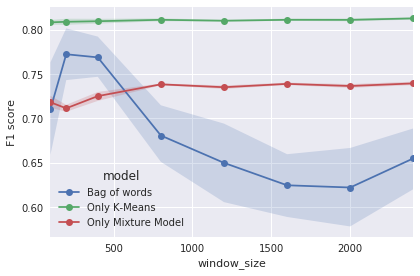

In [21]:
import seaborn as sns
d = {
        s: {
            'Bag of words': bow_s[s],
            'Only K-Means': only_kmeans_s[s],
            'Only Mixture Model': only_gmm_s[s],
        }
    for s in bow_s.keys()
}

with sns.axes_style("darkgrid"):
    evaluate.analyze_tseries(d, "window_size", "model")
    #evaluate.analyze_cnns(d, "num. training samples", "model", "../report/figures/results/training-size-old")

# Training size, older test set

In [28]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

num_clusters = 9
window_size = (0, 1)
k = 5

#old_baseline_s = {}
#old_kmeans_s = {}
#old_gmm_s = {}
#old_char_baseline_s = {}
#old_char_kmeans_s = {}
#old_char_gmm_s = {}


for training_size in [100, 200]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)
    splitter = evaluate.StratifiedShuffleSplit(
        n_splits=k,
        train_size=training_size,
        test_size=None,
        random_state=100,
    )

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, False, True, False, False, True], optim_fn,
                                dataset,
                                params=[params, params, params, char_params, char_params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    
    old_baseline_s[training_size] = [v[0] for v in values]
    old_kmeans_s[training_size] = [v[1] for v in values]
    old_gmm_s[training_size] = [v[2] for v in values]
    old_char_baseline_s[training_size] = [v[3] for v in values]
    old_char_kmeans_s[training_size] = [v[4] for v in values]
    old_char_gmm_s[training_size] = [v[5] for v in values]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.67it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[1355  856  137 1095   94 3299 2805 1877 2139 1223 3200 3517 3846  417
 2882 2871 3233  782 3175  654 3246 3137 2587 1996  548 2657  239   57
  799 1676  765 2039  964 1883 3045 1530 1085  577 1894  269 3329 3330
 2829 1357  423 2550 1313 1783 3268 3645 3828 1343 1315 2077  552 3413
 1613 2519 3779 1153  142 2875 1274 2426 2814 1352  860 2206  353 2469
  790 2827   53 1816 2510 1712 1574 2005 2413 2460 1103 1180 2316  817
 3488 2226  684 3694 1006 1392  453 2704  467 3648  580  928  569  648
  608 2553]
100 training samples, 1132 testing samples


Training:  12%|█▏        | 24/200 [00:03<00:27,  6.46it/s, f1=0.81, Δf1=-0.0227]

 20%|██        | 1/5 [00:47<03:11, 47.92s/it]

[1320 2238 1835 3685 1745 3385 3032 1474 3205 1181 1131 3050 1524 3440
 1976  445 1811 3004  882 1959 2730 2083 2082 1223 1797  353 1988  656
  471 2589 1958  711 3868 2952   38  758 1350  394  475 1232 2147 2049
 2123 2875 3298 2880 2293 2536 2329 2543  272  681  582 1434 3258 1941
 3031  773 1307 3110 1761 1733 2981 2154 1974 1040 2164  890 3206  728
   30 2685  740 1081 1280 2274 3351 2778 2383 3411 2906 3220   41 1796
 3073 1896 3668 2963 2707  647 2760  281 1977 3880 3289 2190   84 1497
 3515 3879]


Training:   7%|▋         | 14/200 [00:02<00:30,  6.20it/s, f1=0.806, Δf1=0]     

 40%|████      | 2/5 [01:24<02:06, 42.23s/it]

[3855 2939 2051 2630 2708  606  754 2410 1675 1297 1069 3060  819 1480
 1027 2649 2568 3621 3464 2490  683 1947 1833 1141 2754 3015 1775 1956
 3813  228 1328 1706  613 1099  192 1822  625 2327  791 3637  920 1659
 3074 2061 2042 1292 2850 3648 2727 2820 2790 1343 2595  485 3105  401
 1356 2980 1154 3199  609 3842 3694 3611 1056 3652  988 1759 3634 2726
  971 3332  914 3677 1048 1816  205 2087 3791  949 3180  669 1656  123
 2906 1689  627  496 1000 3478  456 3639 1623 1342 2329 2877  195  405
 3768  139]


Training:  20%|██        | 40/200 [00:06<00:24,  6.64it/s, f1=0.849, Δf1=-0.00214]

 60%|██████    | 3/5 [02:02<01:21, 40.90s/it]

[3697  969  122  796  704 3519  961  910 1702  355 1921 2555 1865  510
  632  785 3297 2324  421 1403  406  106 1076  426  681 1682 2731 3594
  948  379 3626 1941 2021  710 3399  461 3183  963 2604  675 2350 1046
 2916  601  633 2591 1096  981 1037 3126 3026 1065 3464 1266 3815  321
 1487 3468 1359 2062 2998  721 3634  142 2614  477 3785 2967 1012  276
 1835 1048 2558 3791 1091 2364 1577  781 2333  437 1218 1495 1634 2910
  247 2130 2627 1948 2292 3750 1481 1512 3261 2841 1243 2238 1176  331
 3355 2226]


Training:   5%|▌         | 10/200 [00:01<00:28,  6.61it/s, f1=0.817, Δf1=-0.00872]

 80%|████████  | 4/5 [02:37<00:39, 39.49s/it]

[1958 1526  237 2074   98 3248 2899 2158 2897 1057 2942   74 2563 3875
 1842 2479 1827 1694 3345 3801 2265 3726  276 2309 2378 3230 1986  780
 3767 1390 3442 3251  216   75 2065 2199 1870 3322  342  249  182  495
  535 1910 2275 3734  604  576  946 1901   72  956 3315 2025 2805 2779
 3190  338  827  990 1548  996 1552 2390 2450 3477   94 3626 1210  921
 2721 2547 2919 1062  816 2333 3431 1682 2638 3775 2932 1834 2717 1978
  152 2081   27 3290 2500 1718 1800 2593  413 3396 2368 2040 3077 2794
   47  347]


Training:   8%|▊         | 15/200 [00:02<00:27,  6.77it/s, f1=0.814, Δf1=-0.00619]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.46it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[1006 1816 1173  453 3737 1233 1647 1621 1290   92 3566 1479 3517 3200
 1355 1877 1454 2532  577   17 3757 1085    8 1274 3488  204  964 3299
 3175 1894 1701 1848 3779 2149 3233  765 2077  232 1577 1530  236 3828
 2580 2480  670  118   94 1996 2596 1095  517 2316 1676 1678 2300 1263
  185 1730  417 3648 2152 1153 3245 1343 1963 1763  947 1883 2829 3045
 2017 1284  467 3594 3796 2567  548  239 2500   58 2814 3881  710 2704
 3846  580 1303  146  423 2139 3236 1223 2882  684  782 2805 2553 2510
  963 1449 2005 3137 1574 1925 2657 1315 2426 2413 3330 3329  269 2871
 3142 2875 2550  869 2714 3401   57 2599 3669 1177 1712  137 3246 1352
  569 2810 2214  726 3268 2627 1091 2160 3478 2837  799 3713 1426 1357
 3123  648 2092  552 2501 3645 2469 1612 2228  856 3129 3716  150 1313
 1783 3795  142 1214  654 1613 2150  599 2587  556 3053  860 2206 1570
 1412  790 2827   53 3752 2519  532  285 2460 1103 1180  394  817 2226
 2039  353  506 1592 3694 2735 1392 2279 3054 1767 3290 2391  928 3663
 3731 

Training:  14%|█▍        | 29/200 [00:05<00:34,  4.93it/s, f1=0.846, Δf1=-0.00426]

 20%|██        | 1/5 [00:45<03:03, 45.87s/it]

[2034 3603 2562 1624 2568  876 2199 1738 3049 2555 1437 1684 2893 2678
 2424 2410  942 1046 3206   30 3255 3788  185 2451  855 3702 1257 2528
 2443 2379 2362 3762 3036 3130 2083 1634  650 1574 1341 1833 2303 1717
  575 2198  382 1968  554  813  503  569 3521 3381  136 1610 3490 1062
  471  490 3239  969 2138 2898  728   84 2951 2552 2321 1444 3295 2348
 3328 2792 3453 1263  342 2723 2753 1349 2646 1273  900  498 3541  162
 1696  428 3095  961 1718 3155 1767 2846 3118 3561 1510 1147  534 1889
  182 3044  239 3042 1786 1526 1104 1156  541 2650  465 1811  276 2238
 3112 3115  890 3846 3726 1230 3691 1407 1578 3344  615  773  882 3406
   63 1374 1096 1827 3218 1685 2488 2675 3129 3610  586 1617  663 2213
 2925   41   38   16 3477  798  353 2737 3172  520 2574  999 2529 2053
 1201 3755 1212 1482 2978  480 1085 3156 1539 1645 3761 1567 3475 1448
  948 1823  475 2075 2299 1886  899 1318 3145 2647 3605 1040 3176  938
  941 3108 2799 3774 2290 2336 3136  445 1232 3479 2868  786 1573 1762
 2054 

Training:  45%|████▌     | 90/200 [00:17<00:21,  5.07it/s, f1=0.877, Δf1=-0.00292] 

 40%|████      | 2/5 [01:51<02:46, 55.61s/it]

[1436 1552 3671 1514 3551 2220  509 2271  622 1268 3108 3441 3269  373
  613  688 2257 3085  400  273 2098 1928 3626 1171 1753 1031 3557 2494
  192 1899  331 1350 1069 1008 1768 1032   93 3308  355  943  920 2046
 3384 2549 2099  383 1476 3116 1498 3077 3277 2559 2940 1559  120 1949
  600 3086 3162 1631 1462 2229 2736 3589 1415 3114 2127 2156 1256 1757
  468 1617  975  338 3522  700 1202 2864 3447  456 3263  242 2891  998
 3811 2215 3072 1309 2065 1388 2223  722 2264  139 2708 1185  597 3617
 1085 2580  857  842  667 3668 1956  754 2816 1059  847 2376  574 2050
 2022 2411   18  508 3365 3241 1052 2551 1470  611 2043 2890  423 2105
  596 3292  195 2114 1980 2442   51  205  686 1586 3151 1335 1503 1058
 3111 2198 1267 2832 3113 1488 3270 2994 3018 3344  416 1620 2799 1805
 1015 1475 3730 3470 2715  752 1100  228 1963 3452 2780 2214  851 3060
 2817 1166 2755 3706 1831 2242 2751  707 2233  988 2124  374 3832 2833
 1623 3519  959 2007 1319 3879  708 2019 3807 3379 3177 2846 2341 3009
 3030 

Training:  15%|█▌        | 30/200 [00:05<00:33,  5.07it/s, f1=0.798, Δf1=-0.0393]

 60%|██████    | 3/5 [02:46<01:51, 55.52s/it]

[2723 3866 2010  765  595  647 1845  430  154 2326 2078 3699  182 3752
  633 3363  309 2889  579 2133 3634 1418  519 3132  549 2299 3001 3468
 1838 1778 2305 3300  841  695  878 2096  114   86 3584  796  620 3021
 2507 3403 2064 2520 3393 3285 2954 1532  256  653 2823 2162 3201  542
 2873 2241 1375 3374 2929 3810 1028  691  645  411  331   90 3037 2038
   91 1228 1009 1359 2763 2630 2990 2559 1186 1804 3737 1695  235 2828
  815 1135  474 2647  634 1674  996 1941 1362 1139 1388 3828 2062 3025
 1027 1332 3475 2209 3251 1438 2276 1729  453 1762 1245 2109 3619  584
 3742 1953 2680 2271 1580  758 2805 2600 3782 1740 1229 2718  566 3805
  631 1960 3754 1049 2342 3686 3299  690 3566 3883 1300  668 1266  942
  445  268 2706  973 3718 2781 1219  740 1307  321 3518 3367  517 1278
 1456 2150 1224 3364 3215 1666 2568  590 2574 3413 1395 2733 1113 1760
  247 2713 2266  876    6    9 3077  521  400 2360 2356  607 1783  797
 3387 1090 1966  848 1615 3260 3064 2788  225 3323 2974  721 2067 3846
 3629 

Training:  18%|█▊        | 35/200 [00:06<00:32,  5.13it/s, f1=0.832, Δf1=-0.016]  

 80%|████████  | 4/5 [03:30<00:52, 52.63s/it]

[2904    3 1710  812  143 1304 3563 3106 3241  330 2442 3160 3711 3783
 3078  967 3773  823  273  566 3800 3401 2382 2288  515 1450 2172  368
 1890 1579  836 2580 3264  276 3614 3531 1366  943  514 1388 3585 3119
 2783 2624 3024 3725 3626   67 1784 2687 1900 2918 1655  596 3000  946
  380  565  409 3739 2677  370 1406  758 3624 1444 3102 1972 1290 3353
 1577 2645 3548 2978 1142 3580 3775 1863 3566  602 2886 3179 1997  358
 3208 3182 2187 1440  347 2887 1047 1046 1228 3149  735  392 1820 2611
 2990 1072 1232  578 2308 3071 2291 1231 1301 1733 2833 3707   72 1508
 2776 2943 2889 1269 2514  853 1783 1572 2304 2789 3858  132 3131  216
 2734 1679  549 1136 2314 2792 1592 1928 1627 3881 2561 1634  340 2626
 2509 1839  229 1881 2195 1641  888  307 3357  873 3199 1938 1946 3430
  525  194 1375 1924 2963 3719 2958 2606 2973 3255 3148  835 1081 2850
 2949 3666 2175 3769 1456 3840 1048  422 2422 2047 2882 3857 2496  489
 1623 2313 2657 1176  342 3088 1763 1171  838 3458  816 2036  469  264
 2084 

Training:  10%|█         | 20/200 [00:03<00:34,  5.19it/s, f1=0.835, Δf1=-0.0111]

100%|██████████| 5/5 [04:16<00:00, 51.36s/it]


/usr/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


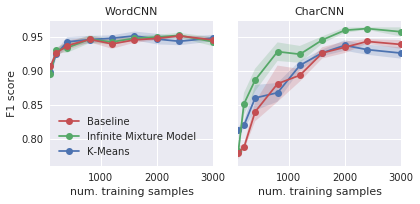

In [38]:
import seaborn as sns
d = {
    "WordCNN": {
        s: {
            'K-Means': old_kmeans_s[s],
            'Infinite Mixture Model': old_gmm_s[s],
            'Baseline': old_baseline_s[s],
        }
        for s in old_kmeans_s.keys()
    },
    "CharCNN": {
        s: {
            'K-Means': old_char_kmeans_s[s],
            'Infinite Mixture Model': old_char_gmm_s[s],
            'Baseline': old_char_baseline_s[s],
        }
        for s in old_kmeans_s.keys()
    }
}

with sns.axes_style("darkgrid"):
    #evaluate.analyze_cnns(d, "window_size", "model")
    evaluate.analyze_cnns(d, "num. training samples", "model", "../report/figures/results/training-size-old")

In [33]:
save((old_baseline_s, old_kmeans_s, old_gmm_s, old_char_baseline_s, old_char_kmeans_s, old_char_gmm_s), "training-size-old.pkl")

# Window size, full cross validation

In [34]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=100,
    max_norm=3,
)

#optim_fn = lambda p: torch.optim.Adadelta(p)
optim_fn = lambda p: torch.optim.Adam(p, weight_decay=0.0001)
model_fns = [lambda r: models.NoClusterLabels(r, params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
             
             lambda r: models.NoClusterLabels(r, char_params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, char_params.dropout)]
    
#baseline = {}
#kmeans = {}
#char_baseline = {}
#char_kmeans = {}

for window_size in [1]:
    num_clusters = 9
    dataset, validset = evaluate.load_dataset(num_clusters, window_size)

    values = evaluate.cross_val(5, 1600, model_fns, [False, False, False, False], optim_fn, dataset,
                                params=[params, params, char_params, char_params],
                                early_stopping=10,
                                validation_set=None,
                                batch_size=128,
                                testset=None)
    baseline[window_size] = [v[0] for v in values]
    kmeans[window_size] = [v[1] for v in values]
    char_baseline[window_size] = [v[2] for v in values]
    char_kmeans[window_size] = [v[3] for v in values]

Creating dictionary:  71%|█████████████████████████████████████████████▉                   | 12/17 [00:02<00:01,  4.92it/s]


KeyboardInterrupt: 

In [ ]:
d = {
    "WordCNN": {
        s: {
            'Baseline': baseline[s],
            'K-Means': kmeans[s],
        }
        for s in baseline.keys()
    },
    "CharCNN": {
        s: {
            'Baseline': char_baseline[s],
            'K-Means': char_kmeans[s],
        }
        for s in baseline.keys()
    }
}
#evaluate.analyze_tseries(d, 'window size', 'model')
evaluate.analyze_cnns(d, "window size", "model", "../report/figures/results/1600-windowsize")

# Window size, older testset

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

num_clusters = 9
k = 5
splitter = evaluate.StratifiedShuffleSplit(
    n_splits=k,
    train_size=2000,
    test_size=None,
    random_state=100,
)

old_kmeans_w = {}
old_gmm_w = {}
old_char_kmeans_w = {}
old_char_gmm_w = {}
old_baseline_w = {}
old_char_baseline_w = {}

for window_size in [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
        lambda r: models.NoClusterLabels(r, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, False, True, False, False, True], optim_fn,
                                dataset,
                                params=[params, params, params, char_params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset,
                               )
    old_baseline_w[window_size] = [v[0] for v in values]
    old_kmeans_w[window_size] = [v[1] for v in values]
    old_gmm_w[window_size] = [v[2] for v in values]
    old_char_baseline_w[window_size] = [v[3] for v in values]
    old_char_kmeans_w[window_size] = [v[4] for v in values]
    old_char_gmm_w[window_size] = [v[5] for v in values]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


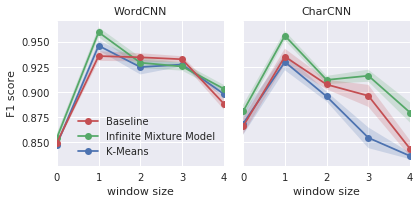

In [37]:
d = {
    "WordCNN": {
        sum(s): {
            'K-Means': old_kmeans_w[s],
            'Infinite Mixture Model': old_gmm_w[s],
            'Baseline': old_baseline_w[s],
        }
        for s in old_kmeans_w.keys()
    },
    "CharCNN": {
        sum(s): {
            'K-Means': old_char_kmeans_w[s],
            'Infinite Mixture Model': old_char_gmm_w[s],
            'Baseline': old_char_baseline_w[s],
        }
        for s in old_kmeans_w.keys()
    }
}
#evaluate.analyze_cnns(d, "window_size", "model")
evaluate.analyze_cnns(d, "window size", "model", "../report/figures/results/2000-windowsize-old")

In [13]:
save((old_baseline, old_kmeans_w, old_gmm_w, old_char_baseline, old_char_kmeans_w, old_char_gmm_w), "2000-windowsize-old.pkl")

# Number of clusters, full cross validation

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

optim_fn = lambda p: torch.optim.Adadelta(p)
model_fns = [lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
#             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
    
kmeans = {}
gmm = {}

for num_clusters in [2, 3, 5, 7, 9, 15, 30]:
    window_size = 5
    dataset, validset = load_dataset(num_clusters, window_size)

    values = evaluate.cross_val(10, 1200, model_fns, [False], optim_fn, dataset, params,
                                early_stopping=10,
                                validation_set=validset,
                                testset=None)
    kmeans[num_clusters] = [v[0] for v in values]
    gmm[num_clusters] = [v[1] for v in values]

In [ ]:
d = {s: {'K-Means': kmeans[s],
         #'Mixture model': gmm[s],
        }
    for s in kmeans.keys()
}
#evaluate.analyze_tseries(d, 'k', 'model')
evaluate.analyze_size(d, 'k', 'model', '../report/figures/results/800-numcluster')
evaluate.analyze_tseries(d, 'k', 'model', '../report/figures/results/800-numcluster')

# Number of clusters on old training set

In [15]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

window_size = (0, 1)
k = 5
splitter = evaluate.StratifiedShuffleSplit(
    n_splits=k,
    train_size=2000,
    test_size=None,
    random_state=100,
)

old_kmeans_cls = {}
old_gmm_cls = {}
old_char_kmeans_cls = {}
old_char_gmm_cls = {}

for num_clusters in [2, 3, 5, 7, 9, 15, 30]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
    ]

    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, True, False, True], optim_fn,
                                dataset,
                                params=[params, params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    old_kmeans_cls[num_clusters] = [v[0] for v in values]
    old_gmm_cls[num_clusters] = [v[1] for v in values]
    old_char_kmeans_cls[num_clusters] = [v[2] for v in values]
    old_char_gmm_cls[num_clusters] = [v[3] for v in values]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  55%|█████▌    | 110/200 [01:47<01:28,  1.02it/s, f1=0.944, Δf1=0]       

 20%|██        | 1/5 [03:51<15:24, 231.11s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  15%|█▌        | 30/200 [00:28<02:43,  1.04it/s, f1=0.929, Δf1=-0.00773]

 40%|████      | 2/5 [05:50<08:45, 175.18s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  15%|█▌        | 30/200 [00:28<02:42,  1.05it/s, f1=0.947, Δf1=-0.000382]

 60%|██████    | 3/5 [07:34<05:03, 151.50s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  12%|█▎        | 25/200 [00:23<02:46,  1.05it/s, f1=0.926, Δf1=-0.0193]

 80%|████████  | 4/5 [09:09<02:17, 137.45s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  40%|████      | 80/200 [01:16<01:55,  1.04it/s, f1=0.963, Δf1=-0.000268]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.77it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  18%|█▊        | 35/200 [00:33<02:37,  1.05it/s, f1=0.943, Δf1=-0.000426]

 20%|██        | 1/5 [01:36<06:27, 96.78s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  35%|███▌      | 70/200 [01:06<02:04,  1.05it/s, f1=0.939, Δf1=-0.00109]

 40%|████      | 2/5 [04:24<06:36, 132.12s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  28%|██▊       | 55/200 [00:52<02:18,  1.05it/s, f1=0.953, Δf1=0]        

 60%|██████    | 3/5 [06:43<04:29, 134.63s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  45%|████▌     | 90/200 [01:26<01:45,  1.04it/s, f1=0.945, Δf1=0]        

 80%|████████  | 4/5 [09:32<02:23, 143.21s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  15%|█▌        | 30/200 [00:28<02:42,  1.05it/s, f1=0.956, Δf1=-0.00221]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.58it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  30%|███       | 60/200 [00:57<02:13,  1.05it/s, f1=0.932, Δf1=0]       

 20%|██        | 1/5 [02:04<08:16, 124.07s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  32%|███▎      | 65/200 [01:02<02:09,  1.04it/s, f1=0.957, Δf1=0]        

 40%|████      | 2/5 [04:13<06:20, 126.93s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  45%|████▌     | 90/200 [01:26<01:46,  1.04it/s, f1=0.942, Δf1=0]        

 60%|██████    | 3/5 [07:02<04:41, 140.84s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  48%|████▊     | 95/200 [01:31<01:41,  1.04it/s, f1=0.933, Δf1=0]       

 80%|████████  | 4/5 [09:48<02:27, 147.00s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  12%|█▎        | 25/200 [00:24<02:49,  1.03it/s, f1=0.952, Δf1=-0.000199]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.58it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  32%|███▎      | 65/200 [01:02<02:10,  1.04it/s, f1=0.942, Δf1=0]        

 20%|██        | 1/5 [02:17<09:09, 137.29s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  45%|████▌     | 90/200 [01:28<01:48,  1.02it/s, f1=0.927, Δf1=0]       

 40%|████      | 2/5 [05:06<07:39, 153.20s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  48%|████▊     | 95/200 [01:34<01:44,  1.01it/s, f1=0.951, Δf1=0]        

 60%|██████    | 3/5 [07:56<05:17, 158.84s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  35%|███▌      | 70/200 [01:10<02:10,  1.00s/it, f1=0.928, Δf1=0]        

 80%|████████  | 4/5 [10:13<02:33, 153.34s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  12%|█▎        | 25/200 [00:24<02:49,  1.03it/s, f1=0.946, Δf1=-0.00286]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  28%|██▊       | 55/200 [00:55<02:26,  1.01s/it, f1=0.945, Δf1=-0.000277]

 20%|██        | 1/5 [02:13<08:55, 133.96s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  10%|█         | 20/200 [00:20<03:06,  1.04s/it, f1=0.943, Δf1=-0.001]

 40%|████      | 2/5 [04:42<07:03, 141.01s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  25%|██▌       | 50/200 [00:51<02:34,  1.03s/it, f1=0.953, Δf1=-0.000536]

 60%|██████    | 3/5 [07:12<04:48, 144.14s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  30%|███       | 60/200 [01:03<02:28,  1.06s/it, f1=0.949, Δf1=-0.000103]

 80%|████████  | 4/5 [09:56<02:29, 149.15s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  20%|██        | 40/200 [00:39<02:37,  1.02it/s, f1=0.965, Δf1=0]       

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.61it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  20%|██        | 40/200 [00:39<02:37,  1.01it/s, f1=0.942, Δf1=-0.000872]

 20%|██        | 1/5 [02:00<08:02, 120.70s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  15%|█▌        | 30/200 [00:29<02:48,  1.01it/s, f1=0.955, Δf1=-0.000562]

 40%|████      | 2/5 [03:41<05:31, 110.53s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  22%|██▎       | 45/200 [00:44<02:31,  1.02it/s, f1=0.944, Δf1=-0.00049] 

 60%|██████    | 3/5 [05:30<03:40, 110.11s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  22%|██▎       | 45/200 [00:44<02:33,  1.01it/s, f1=0.929, Δf1=-0.00196]

 80%|████████  | 4/5 [07:55<01:58, 118.81s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  12%|█▎        | 25/200 [00:25<02:56,  1.01s/it, f1=0.945, Δf1=-0.00156]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.38it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  35%|███▌      | 70/200 [01:16<02:22,  1.10s/it, f1=0.939, Δf1=0]       

 20%|██        | 1/5 [03:13<12:52, 193.23s/it]

[3442 1761 2281 ...  231 1316 2548]


Training:  20%|██        | 40/200 [00:41<02:44,  1.03s/it, f1=0.949, Δf1=-0.000664]

 40%|████      | 2/5 [05:50<08:46, 175.45s/it]

[  10  683 2628 ... 1125 1557 3658]


Training:  40%|████      | 80/200 [01:22<02:04,  1.04s/it, f1=0.954, Δf1=-0.000486]

 60%|██████    | 3/5 [08:39<05:46, 173.21s/it]

[2362 3138 1297 ...  205 2287 1247]


Training:  28%|██▊       | 55/200 [00:59<02:36,  1.08s/it, f1=0.953, Δf1=0]       

 80%|████████  | 4/5 [11:02<02:45, 165.72s/it]

[3690 3243 2192 ... 2801 1146 2757]


Training:  22%|██▎       | 45/200 [00:48<02:47,  1.08s/it, f1=0.957, Δf1=-0.00106] 

100%|██████████| 5/5 [13:48<00:00, 165.70s/it]


In [4]:
(old_kmeans_cls, old_gmm_cls, old_char_kmeans_cls, old_char_gmm_cls) = load("1600-numclusters-old.pkl")

/usr/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


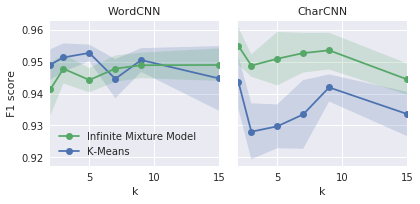

In [36]:
d = {
    "WordCNN": {
        s: {
            'K-Means': old_kmeans_cls[s],
            'Infinite Mixture Model': old_gmm_cls[s],
        }
        for s in old_kmeans_cls.keys()
    },
    "CharCNN": {
        s: {
            'K-Means': old_char_kmeans_cls[s],
            'Infinite Mixture Model': old_char_gmm_cls[s],
        }
        for s in [2, 3, 5, 7, 9, 15]
    }
}
with sns.axes_style("darkgrid"):
    #evaluate.analyze_cnns(d, "k", "model")
    evaluate.analyze_cnns(d, "k", "model", "../report/figures/results/2000-numclusters-old")

In [17]:
save((old_kmeans_cls, old_gmm_cls, old_char_kmeans_cls, old_char_gmm_cls), "2000-numclusters-old.pkl")